In [1]:
# 필요한 패키지와 라이브러리를 가져옴
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
import numpy as np
import pandas as pd


In [3]:
data = pd.read_table('221028_ratings.txt')

# 데이터 파악
# data.head()
print('중복 제거 전 데이터 길이 :' ,  len(data))
# document의 nunique값과 label의 nunique값을 확인해서
# len길이와 다르면 중복값이 있다는 거다.
data['document'].nunique(), data['label'].nunique() 
# 출력값을 통해 document에는 중복값이 있고, 
# label에는 2개의 값이 있다는 것을 알 수 있다.

데이터 길이 : 200000


(194543, 2)

In [5]:
# document의 중복값을 없애준다. (원본 대체)
# data.drop_duplicates(subset=['document'], inplace=True)
data = data.drop_duplicates(subset=['document'])

# 중복값을 제거한 후 길이를 확인해보자!
print('중복 제거 후 데이터 길이 :' ,  len(data))
data['document'].nunique(), data['label'].nunique() 

중복 제거 후 데이터 길이 : 194544


(194543, 2)

In [8]:
data['label'].unique()

array([1, 0], dtype=int64)

<AxesSubplot:>

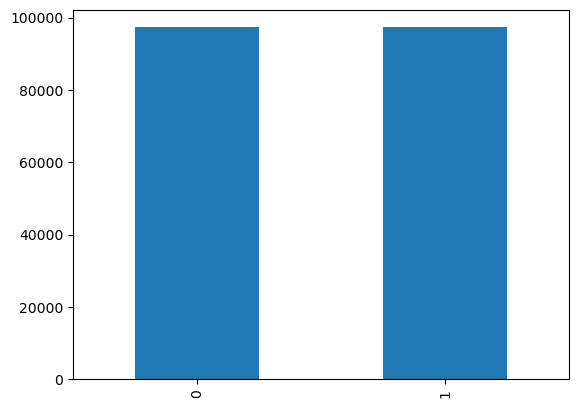

In [ ]:
# 각각의 레이블 값을 시각화해서 보기(? 왜 ??)
data['label'].value_counts().plot(kind = 'bar')

https://blog.naver.com/PostView.nhn?blogId=youji4ever&logNo=222405683851  
##### size와 count의 차이  
- size는 호출된 객체의 크기 또는 길이를 반환한다  
- size는 NaN이 있는 부분도 "포함"해서 계사하지만.  
- count는 NaN 값을 "무시"하고 계산한다.

In [22]:
# data.groupby('label').size()
# data.groupby('label').count()

In [ ]:
print(data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  97277
1      1  97267


In [ ]:
print(data.isnull().values.any())

True


In [ ]:
print(data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [ ]:
data.loc[data.document.isnull()]

,id,document,label
46471,6369843,NaN,1


In [ ]:
data = data.dropna(how = 'any')
print(data.isnull().values.any())

False


In [ ]:
print(len(data))

194543


In [ ]:
data['document'] = data['document'].str.replace("[^ㄱ-하-ㅣ가힣]"," ")
data.isnull().values.any()

C:\Users\user\AppData\Local\Temp\ipykernel_23360\4230409944.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data['document'] = data['document'].str.replace("[^ㄱ-하-ㅣ가힣]"," ")


False

In [ ]:
data['document'].replace('',np.nan,inplace=True)
print(data.isnull().sum())

id          0
document    0
label       0
dtype: int64


In [ ]:
data.loc[data.document.isnull()]

,id,document,label


In [ ]:
data = data.dropna(how='any')
print(len(data))


194543


토큰화

In [ ]:
from sklearn.model_selection import train_test_split
x_train, X_test, y_train, y_test = train_test_split(list(data['document']))

ValueError: not enough values to unpack (expected 4, got 2)

In [ ]:
#불용어 정의(조사나 접속사 등)
stopwords = ['의','가','이','은','들',
             '는','좀','잘','걍','과',
             '도','를','으로','자','에',
             '와','한','하다']

In [ ]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔',
           stem = True) # 어간추출

# 결과값 
# ['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [ ]:
train_x = []
from tqdm import tqdm
for sentence in tqdm(data['document']):
# for sentence in tqdm(train_x):
    temp_X = []
    temp_X = okt.morphs(sentence, stem = True)
    temp_X = [word for word in temp_X if not word in stopwords]
    train_x.append(temp_X)
    
print(train_x[:5])
    

 35%|███▌      | 68621/194543 [01:28<02:41, 777.62it/s]


KeyboardInterrupt: 

In [ ]:
x_train = x_train[:10000]
x_test = x_test[:10000]
y_train = y_train[:10000]
y_test = y_test[:10000]

SyntaxError: unexpected EOF while parsing (2178374066.py, line 4)

In [ ]:
test_x = []
from tqdm import tqdm
for sentence in tqdm(test_x):
    temp_X = []
    temp_X = okt.morphs(sentence, stem = True)
    temp_X = [word for word in temp_X if not word in stopwords]
    test_x.append(temp_X)
    
print(test_x[:5])

### Word3vec

In [ ]:
from gensim.models import Word2Vec

In [ ]:
model = Word2Vec(train_x, 
                 vector_size=300, #한국어의 경우 50~300으로 설정하는데, 보통 100,200,300으로 설정한다. 
                 window=3, #앞뒤로 파악할 단어의 개수
                 min_count = 5, #단어가 적어도 몇 번 이상 나와야 한다
                 workers=1) #

In [ ]:
w2v = Word2Vec(train_x, vector_size=300, window=3, min_count=3)
word_vectors = w2v.wv
vocabs = word_vectors.key_to_index

In [ ]:
word_vectors_list = [word_vectors[v] for v in vocabs]
print(word_vectors_list[:5])

[array([-0.17505096,  0.99550366,  0.18243499,  0.41333696, -0.7469492 ,
       -0.6732836 ,  0.6777745 ,  0.64380765, -0.6159085 ,  0.01536939,
        0.09890989, -0.31112748, -0.26538336, -0.23237836, -0.58124286,
       -0.45147076,  0.3985237 ,  0.32010597, -0.41843826, -1.0339732 ,
       -0.09756855,  0.44465283,  0.31440642,  0.12516032, -0.15300004,
       -0.15379216, -0.23072235,  0.10854387, -0.2545466 ,  0.06001792,
       -0.29317278, -0.08067669,  0.78245693, -0.3420989 , -0.32050815,
       -0.08398137,  1.0530604 , -0.8494907 ,  0.12695312, -0.35127592,
       -0.32216674,  0.09097853, -0.31835824, -0.83307284,  0.56743354,
        0.5425456 , -0.7088776 ,  0.28738043,  0.00447714, -0.10223973,
       -0.048563  ,  0.3353039 , -0.14862606,  0.0762733 ,  0.5004262 ,
       -0.69617635,  0.06200235, -0.19435872,  0.21993418,  0.593289  ,
        0.02333567, -0.21509868, -0.4223263 , -0.1393692 ,  0.2533309 ,
       -0.18678693, -0.02579919, -0.00337286, -0.10716166,  0.2

In [ ]:
# 유사한 단어 뽑아보기
w2v.wv.most_similar('관객')

[('스스로', 0.9006479382514954),
 ('그것', 0.8897421360015869),
 ('영역', 0.8885618448257446),
 ('법', 0.8871834874153137),
 ('질문', 0.8866530656814575),
 ('편견', 0.8862565755844116),
 ('자기', 0.8848274350166321),
 ('다물다', 0.8816104531288147),
 ('자존감', 0.8799077868461609),
 ('비난', 0.8798646330833435)]

In [ ]:
# 학습된 모델 설정
w2v.save('w2v.bin')


In [ ]:
# 저장된 모델 불러오기 
saved_w2v = Word2Vec.load('w2v.bin')
print(saved_w2v)